In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.3.1
sys.version_info(major=3, minor=6, micro=7, releaselevel='final', serial=0)
matplotlib 3.3.2
numpy 1.18.4
pandas 1.1.4
sklearn 0.23.2
tensorflow 2.3.1
tensorflow.keras 2.4.0


In [3]:
# https://storage.googleapis.com/tf-datasets/titanic/eval.csv
train_file = "./data/titanic/train.csv"
eval_file = "./data/titanic/eval.csv"

train_df = pd.read_csv(train_file)
eval_df = pd.read_csv(eval_file)

In [4]:
train_df.head()

survived     sex   age  n_siblings_spouses  parch     fare  class     deck  \
0         0    male  22.0                   1      0   7.2500  Third  unknown   
1         1  female  38.0                   1      0  71.2833  First        C   
2         1  female  26.0                   0      0   7.9250  Third  unknown   
3         1  female  35.0                   1      0  53.1000  First        C   
4         0    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y

In [5]:
eval_df.head()

survived     sex   age  n_siblings_spouses  parch     fare   class  \
0         0    male  35.0                   0      0   8.0500   Third   
1         0    male  54.0                   0      0  51.8625   First   
2         1  female  58.0                   0      0  26.5500   First   
3         1  female  55.0                   0      0  16.0000  Second   
4         1    male  34.0                   0      0  13.0000  Second   

      deck  embark_town alone  
0  unknown  Southampton     y  
1        E  Southampton     y  
2        C  Southampton     y  
3  unknown  Southampton     y  
4        D  Southampton     y

In [6]:
y_train = train_df.pop('survived')
y_eval = eval_df.pop('survived')

In [9]:
train_df.describe()

age  n_siblings_spouses       parch        fare
count  627.000000          627.000000  627.000000  627.000000
mean    29.631308            0.545455    0.379585   34.385399
std     12.511818            1.151090    0.792999   54.597730
min      0.750000            0.000000    0.000000    0.000000
25%     23.000000            0.000000    0.000000    7.895800
50%     28.000000            0.000000    0.000000   15.045800
75%     35.000000            1.000000    0.000000   31.387500
max     80.000000            8.000000    5.000000  512.329200

In [10]:
print(train_df.shape, eval_df.shape)

(627, 9) (264, 9)


<AxesSubplot:>

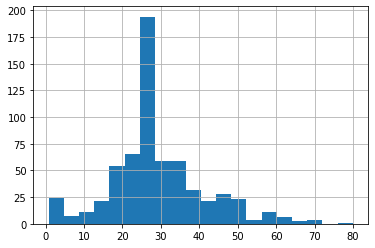

In [11]:
train_df.age.hist(bins = 20)

<AxesSubplot:>

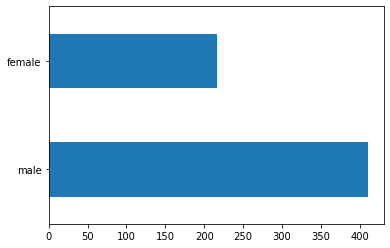

In [12]:
train_df.sex.value_counts().plot(kind = 'barh')

<AxesSubplot:>

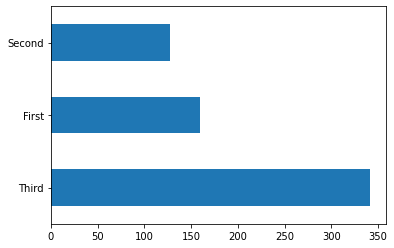

In [13]:
train_df['class'].value_counts().plot(kind = 'barh')  # 注意函数冲突

<AxesSubplot:ylabel='sex'>

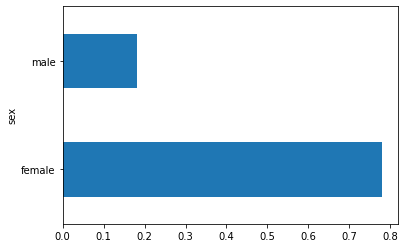

In [14]:
pd.concat([train_df, y_train], axis = 1).groupby('sex').survived.mean().plot(kind='barh')

## 模型搭建

In [18]:
categorical_columns = ['sex', 'n_siblings_spouses', 'parch', 'class',
                       'deck', 'embark_town', 'alone']
numeric_columns = ['age', 'fare']

feature_columns = []
for categorical_column in categorical_columns:
    vocab = train_df[categorical_column].unique()
    print(categorical_column, vocab)
    feature_columns.append(
        tf.feature_column.indicator_column(
            tf.feature_column.categorical_column_with_vocabulary_list(
                categorical_column, vocab)))

for numerical_column in numeric_columns:
    feature_columns.append(
        tf.feature_column.numeric_column(
            numerical_column, dtype=tf.float32))

sex ['male' 'female']
n_siblings_spouses [1 0 3 4 2 5 8]
parch [0 1 2 5 3 4]
class ['Third' 'First' 'Second']
deck ['unknown' 'C' 'G' 'A' 'B' 'D' 'F' 'E']
embark_town ['Southampton' 'Cherbourg' 'Queenstown' 'unknown']
alone ['n' 'y']


In [19]:
def make_dataset(data_df, label_df, epochs = 10, shuffle = True, batch_size = 32):
    dataset = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
        dataset = dataset.shuffle(10000)
    dataset = dataset.repeat(epochs).batch(batch_size)
    return dataset

In [22]:
for x, y in train_dataset.take(1):
    print(x, y)

{'sex': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'male', b'male', b'male', b'male', b'male'], dtype=object)>, 'age': <tf.Tensor: shape=(5,), dtype=float64, numpy=array([ 3., 21., 57., 24., 28.])>, 'n_siblings_spouses': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 0, 0, 0, 0], dtype=int64)>, 'parch': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 0, 0, 0, 0], dtype=int64)>, 'fare': <tf.Tensor: shape=(5,), dtype=float64, numpy=array([18.75  ,  7.925 , 12.35  ,  7.8958, 35.5   ])>, 'class': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Second', b'Third', b'Second', b'Third', b'First'], dtype=object)>, 'deck': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'unknown', b'unknown', b'unknown', b'unknown', b'A'], dtype=object)>, 'embark_town': <tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'Southampton', b'Southampton', b'Queenstown', b'Southampton',
       b'Southampton'], dtype=object)>, 'alone': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'

In [25]:
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(2, activation='softmax'),
])
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=['accuracy'])

In [26]:
# 两种方法：
# 1. model.fit 
# 2. model -> estimator -> train

# 1. model.fit
train_dataset = make_dataset(train_df, y_train, epochs = 100)
eval_dataset = make_dataset(eval_df, y_eval, epochs = 1, shuffle = False)
history = model.fit(train_dataset,
                    validation_data = eval_dataset,
                    steps_per_epoch = 19,
                    validation_steps = 8,
                    epochs = 100)

Epoch 1/100
Consider rewriting this model with the Functional API.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Consider rewriting this model with the Functional API.
 1/19 [>.............................] - ETA: 0s - loss: 1.3153 - accuracy: 0.3438WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'sex': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=string>, 'age': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float64>, 'n_siblings_spouses': <tf.Tensor 'ExpandDims_

In [27]:
# Estimator
estimator = keras.estimator.model_to_estimator(model)
# 1. function, can be ananymous
# 2. return a. (features, labels) b. dataset -> (feature, label)
#    Need a function without parameters
#    Use lambda function to encapsulate a function with parameters
estimator.train(input_fn = lambda : make_dataset(train_df, y_train, epochs=100))
# Note: Tensorflow bug!

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
Note that this doesn't affect the state of the model instance you passed as `keras_model` argument.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\lxinp\\AppData\\Local\\Temp\\tmp2i6uhdp7', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_i

ValueError: Unexpectedly found an instance of type `<class 'dict'>`. Expected a symbolic tensor instance.